# Imports

In [669]:
import pandas as pd
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np


In [670]:
df_teams=pd.read_csv('data_merged.csv')

# Feature selection

## Agregation and manual selection

In [671]:
df_teams['GP'] = df_teams['GP'] + df_teams['PostGP']
df_teams['GS'] = df_teams['GS'] + df_teams['PostGS']
df_teams['minutes'] = df_teams['minutes'] + df_teams['PostMinutes']
df_teams['points'] = df_teams['points'] + df_teams['PostPoints']
df_teams['oRebounds'] = df_teams['oRebounds'] + df_teams['PostoRebounds']
df_teams['dRebounds'] = df_teams['dRebounds'] + df_teams['PostdRebounds']
df_teams['rebounds'] = df_teams['rebounds'] + df_teams['PostRebounds']
df_teams['assists'] = df_teams['assists'] + df_teams['PostAssists']
df_teams['steals'] = df_teams['steals'] + df_teams['PostSteals']
df_teams['blocks'] = df_teams['blocks'] + df_teams['PostBlocks']
df_teams['turnovers'] = df_teams['turnovers'] + df_teams['PostTurnovers']
df_teams['PF'] = df_teams['PF'] + df_teams['PostPF']
df_teams['fgAttempted'] = df_teams['fgAttempted'] + df_teams['PostfgAttempted']
df_teams['ftAttempted'] = df_teams['ftAttempted'] + df_teams['PostftAttempted']
df_teams['threeAttempted'] = df_teams['threeAttempted'] + df_teams['PostthreeAttempted']
df_teams['dq'] = df_teams['dq'] + df_teams['PostDQ']

df_teams.drop(columns=['PostGP', 'PostGS', 'PostMinutes', 'PostPoints', 'PostoRebounds', 'PostdRebounds', 'PostRebounds', 'PostAssists', 'PostSteals', 'PostBlocks', 'PostTurnovers', 'PostPF', 'PostfgAttempted', 'PostftAttempted', 'PostthreeAttempted', 'PostDQ'], inplace=True)


In [672]:
df_teams['performance'] = (df_teams['points'] + df_teams['rebounds'] +
                            df_teams['assists'] + df_teams['steals'] +
                            df_teams['blocks']) - (df_teams['turnovers'] +
                            df_teams['PF'])
                            
df_teams.drop(columns=['points', 'rebounds', 'assists', 'steals', 'blocks', 'turnovers', 'PF'], inplace=True)

In basketball, one can calculate the total points scored using the following formula:
Total Points = Free Throws Made (ftMade) + 2 * (Field Goals Made (fgMade) - Three-Pointers Made (threeMade)) + 3 * Three-Pointers Made (threeMade).
However, it's important to note that the given dataset already includes a dedicated column for total points. Consequently, the columns for Free Throws Made (ftMade), Field Goals Made (fgMade), and Three-Pointers Made (threeMade)  end up giving redundant information, and therefore, are not useful and can be deleted from the dataset.

In [673]:

points_made = 1 * df_teams['ftMade'] + 2 * (df_teams['fgMade'] - df_teams['threeMade']) + 3 * df_teams['threeMade']
points_attempted = 1 * df_teams['PostftMade'] + 2 * (df_teams['PostfgMade'] - df_teams['PostthreeMade']) + 3 * df_teams['PostthreeMade']
df_teams['points_precision'] = points_attempted - points_made


df_teams.drop(columns=['ftMade', 'fgMade', 'threeMade', 'PostftMade', 'PostfgMade', 'PostthreeMade'], inplace=True)

The "won" and "lost" collumns is the sum of  "homeW","awayW", "homeL","awayL"


In [674]:
df_teams.drop(columns=["homeW","homeL","awayW","awayL"], inplace=True)

In [675]:
df_teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 42 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   year                     142 non-null    int64  
 1   tmID                     142 non-null    object 
 2   rank                     142 non-null    float64
 3   playoff                  142 non-null    int64  
 4   confW                    142 non-null    float64
 5   confL                    142 non-null    float64
 6   min                      142 non-null    float64
 7   attend                   142 non-null    float64
 8   num_playoff_appearances  142 non-null    float64
 9   total_first_round_won    142 non-null    float64
 10  total_first_round_lost   142 non-null    float64
 11  total_semis_won          142 non-null    float64
 12  total_semis_lost         142 non-null    float64
 13  total_finals_won         142 non-null    float64
 14  total_finals_lost        1

Feature aggregationFrom the players we get the following statistics taht are repeated one for the normal season and one for the playoffs. To eliminate the redundancy we will sum the two columns and then delete the columns that are not needed.

## Function for bi-directional feature selection for each algorithm

In [676]:
def foward_selection(df, model, forward=True, n_jobs=-1):
    X = df.drop(columns=['playoff' ])
    Y = df['playoff']
    ffs = SFS(model, k_features=(5, 20), forward=forward, floating=True, n_jobs=n_jobs)
    ffs.fit(X, Y)
    features = list(ffs.k_feature_names_)
    #if it does not have the 'playoff', 'year', 'tmID', 'confID_EA', 'confID_WE' add it
    if 'playoff' not in features:
        features.append('playoff')
    if 'year' not in features:
        features.append('year')
    if 'tmID' not in features:
        features.append('tmID')
    if 'confID_EA' not in features:
        features.append('confID_EA')
    if 'confID_WE' not in features:
        features.append('confID_WE')
    from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
    fig1 = plot_sfs(ffs.get_metric_dict(), kind='std_dev')
    plt.title('Sequential Forward Selection (w. StdErr)')
    plt.grid()
    plt.show()
    return features


# Train and test

## Functions

In [677]:
def split_data(df):
    # Filter the rows based on the 'confID_EA' and 'confID_EW' values
    confEA_data = df[df['confID_EA'] == 1]
    confEW_data = df[df['confID_WE'] == 1]

    return confEA_data, confEW_data
    

In [678]:
df_teams = df_teams[df_teams['year'] != 1]
#use label encoder to convert categorical data to numerical data of tmID column
le = LabelEncoder()
df_teams['tmID'] = le.fit_transform(df_teams['tmID'])


df_teams.head()


,year,tmID,rank,playoff,confW,confL,min,attend,num_playoff_appearances,total_first_round_won,...,award_count_x,won,lost,post_wins,post_losses,award_count_y,W,L,performance,points_precision
16,2,1,8.0,1,5.0,16.0,6475.0,90963.0,0.0,0.0,...,0.000000,9.0,23.0,0.0,0.0,0.0,0.0,0.0,285.888889,-212.555556
17,2,3,2.0,1,13.0,8.0,6500.0,137532.0,1.0,1.0,...,0.000000,17.0,15.0,3.0,3.0,0.0,3.0,3.0,244.538462,-135.769231
18,2,5,5.0,0,10.0,11.0,6425.0,107289.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,326.285714,-255.142857
19,2,6,2.0,1,17.0,4.0,6475.0,196077.0,1.0,1.0,...,0.142857,27.0,5.0,6.0,0.0,0.0,6.0,0.0,263.142857,-137.285714
20,2,7,7.0,0,7.0,14.0,6425.0,180270.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,272.800000,-203.900000


No need to sample the data, as it is balanced.

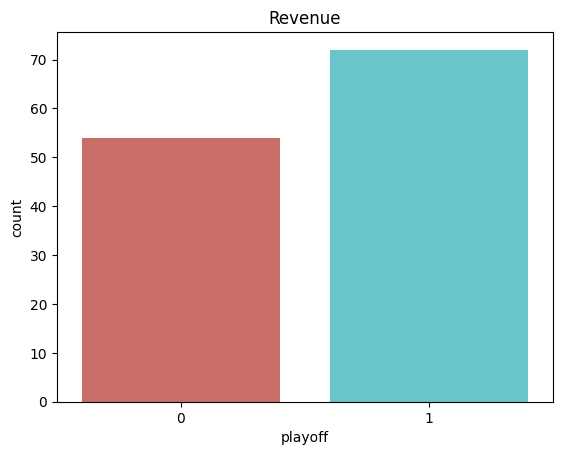

In [679]:
sb.countplot(x='playoff',data=df_teams, palette='hls')
plt.title("Revenue")
plt.show()

In [680]:
from sklearn.decomposition import PCA

def split_and_train(year, model, data, target_col="playoff", scaling=False):
        # Split the data into training and test sets
        train_data = data[data["year"] < year ]
        test_data = data[data["year"] == year ]


        if(scaling):
            scaler = MinMaxScaler()
            train_data = scaler.fit_transform(train_data)
            train_data = pd.DataFrame(train_data, columns=data.columns)
            test_data = scaler.transform(test_data)
            test_data = pd.DataFrame(test_data, columns=data.columns)


        X_train = train_data.drop([target_col], axis=1)
        y_train = train_data[target_col]
        X_test = test_data.drop([target_col], axis=1)
        y_test = test_data[target_col]

        #PCA
        # pca = PCA(n_components=28, svd_solver='full')
        # X_train = pca.fit_transform(X_train)
        # X_test = pca.transform(X_test)

        # Create and train the decision tree model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        #y_pred = model.predict(X_test)
        # Make probability predictions on the test set
        # Sort the probabilities in reverse order and get the indices
        y_prob = model.predict_proba(X_test)
        sorted_indices = np.argsort(-y_prob[:, 1])

        # Set the top 4 predictions with target 1 and others with target 0
        y_pred = np.zeros_like(y_test)
        y_pred[sorted_indices[:4]] = 1
        
        result_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'y_prob': y_prob[:, 1]})


        return y_test, y_pred, y_prob[:, 1]
        


def train_evaluate_decision_tree_graph(model, data, target_col="playoff", scaling=False):
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    years_tested = []

    # Sort the data by the "year" column
    data = data.sort_values(by="year")
    data1, data2 = split_data(data)
    years = sorted(data["year"].unique())

    for year in years[3:]:
       
        y_test1, y_pred1, y_prob1 = split_and_train(year, model, data1, target_col, scaling)
        y_test2, y_pred2, y_prob2 = split_and_train(year, model, data2, target_col, scaling)
        # Merge of 
        # Join y_test1 and y_test2
        y_test = np.concatenate([y_test1, y_test2])

        # Join y_pred1 and y_pred2
        y_pred = np.concatenate([y_pred1, y_pred2])
        
        y_prob = np.concatenate([y_prob1, y_prob2])
        
        result_df = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred, 'y_prob': y_prob})

        # Calculate accuracy and precision
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)
        years_tested.append(year)
        

    return years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores


In [681]:
def plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores):
    # Create a graph to plot accuracy, precision, recall, and f1 over time
    plt.figure(figsize=(20, 5))

    # Plot accuracy
    plt.subplot(1, 4, 1)
    plt.plot(years_tested, accuracy_scores, marker='o')
    plt.title('Accuracy Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 1)  # Set the y-limits between 0.5 and 1


    # Plot precision
    plt.subplot(1, 4, 2)
    plt.plot(years_tested, precision_scores, marker='o', color='orange')
    plt.title('Precision Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Precision')
    plt.ylim(0.5, 1)  # Set the y-limits between 0.5 and 1


    # Plot recall
    plt.subplot(1, 4, 3)
    plt.plot(years_tested, recall_scores, marker='o', color='green')
    plt.title('Recall Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('Recall')
    plt.ylim(0.5, 1)  # Set the y-limits between 0.5 and 1


    # Plot f1
    plt.subplot(1, 4, 4)
    plt.plot(years_tested, f1_scores, marker='o', color='red')
    plt.title('F1 Over Time')
    plt.xlabel('Test Year')
    plt.ylabel('F1')
    plt.ylim(0.5, 1)  # Set the y-limits between 0.5 and 1


    plt.tight_layout()
    plt.show()
    
    # Calculate means
    accuracy_mean = sum(accuracy_scores) / len(accuracy_scores)
    precision_mean = sum(precision_scores) / len(precision_scores)
    recall_mean = sum(recall_scores) / len(recall_scores)
    f1_mean = sum(f1_scores) / len(f1_scores)

    print("Accuracy: ", accuracy_mean)
    print("Precision: ", precision_mean)
    print("Recall: ", recall_mean)
    print("F1: ", f1_mean)


## Models

### Desicion Tree

#### Hyperparameter tuning

In [682]:
from  sklearn.model_selection import GridSearchCV

# model = DecisionTreeClassifier()
# param_grid = {'max_depth': [2, 3, 4, 5, 6, 7, 8, None],
#                 'min_samples_split': [2, 3, 4, 6],
#                 'min_samples_leaf': [1, 2, 3, 4, 5 ],
#                 'criterion': ['gini', 'entropy', 'log_loss'],
#                 'max_features': [None, 'sqrt', 'log2'],
#                 'splitter': ['best', 'random'],
                
#               }
# grid = GridSearchCV(model, param_grid, cv=None)
# X = df_teams.drop(columns=['playoff'])
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_)
#DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=6,splitter='random')


In [683]:
features = foward_selection(df_teams, DecisionTreeClassifier())
print(features)
model = DecisionTreeClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features])
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)


STOPPING EARLY DUE TO KEYBOARD INTERRUPT...

TypeError: 'NoneType' object is not iterable

### Random Forest

#### Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# model = RandomForestClassifier()

# param_grid = {'max_depth': [4, 6, 10, 100, 200, None],
#                 'min_samples_split': [2, 3, 4, 6],
#                 'min_samples_leaf': [1, 2, 3, 4 ],
#                 'max_features': [None, 'sqrt', 'log2'],
#                 'max_leaf_nodes': [None,  6, 7, 10, 20],
#                 'min_impurity_decrease': [0, 0.1, 0.2],
#                 'bootstrap': [False],
#                 'class_weight': ['balanced', 'balanced_subsample', None],
#                 'n_jobs': [None, 2, 3],                
#               }
# grid = RandomizedSearchCV(model, param_grid, cv=None)
# X = df_teams.drop(columns=['playoff'])
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)


In [ ]:
# RandomForestClassifier(bootstrap=False, ccp_alpha=0, class_weight='balanced',
#                        criterion='entropy', max_leaf_nodes=6,
#                        min_impurity_decrease=0.2, min_samples_leaf=4, n_jobs=2) 0.8895384615384616
#                       min_samples_leaf=2, min_samples_split=4, n_jobs=2) 0.8895384615384616
# RandomForestClassifier(bootstrap=False, ccp_alpha=0, class_weight='balanced',
#                        criterion='log_loss', max_depth=10, max_features=None,
#                         max_leaf_nodes=6, min_impurity_decrease=0.2, n_jobs=2) 0.8818461538461537
# RandomForestClassifier(bootstrap=False, ccp_alpha=0, criterion='log_loss',
#                        max_depth=2, max_features='log2', max_leaf_nodes=7,
#                        min_impurity_decrease=0.2, min_samples_leaf=2) 0.8975384615384616
# RandomForestClassifier(ccp_alpha=0.2, max_depth=100, min_impurity_decrease=0,
#                        min_samples_split=4, n_jobs=2, oob_score=True,
#                        warm_start=True) 0.8975384615384616
# RandomForestClassifier(ccp_alpha=0, max_depth=100, max_features=None,
#                        min_impurity_decrease=0, min_samples_leaf=3,
#                        min_samples_split=6, n_jobs=3) 0.8821538461538461


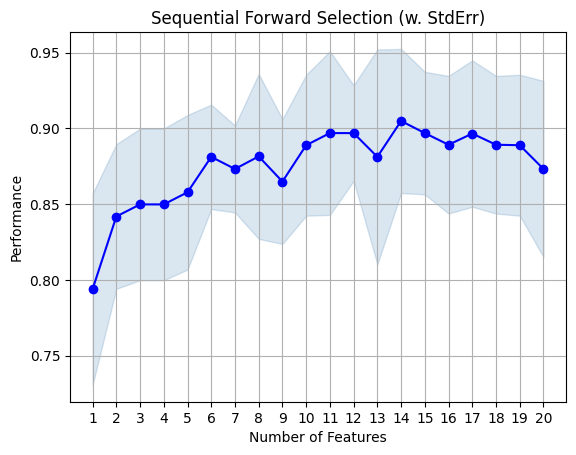

['tmID', 'confL', 'num_playoff_appearances', 'total_first_round_won', 'total_first_round_lost', 'total_semis_won', 'total_semis_lost', 'total_wins', 'total_losses', 'GS', 'dq', 'post_losses', 'W', 'L', 'playoff', 'year', 'confID_EA', 'confID_WE']


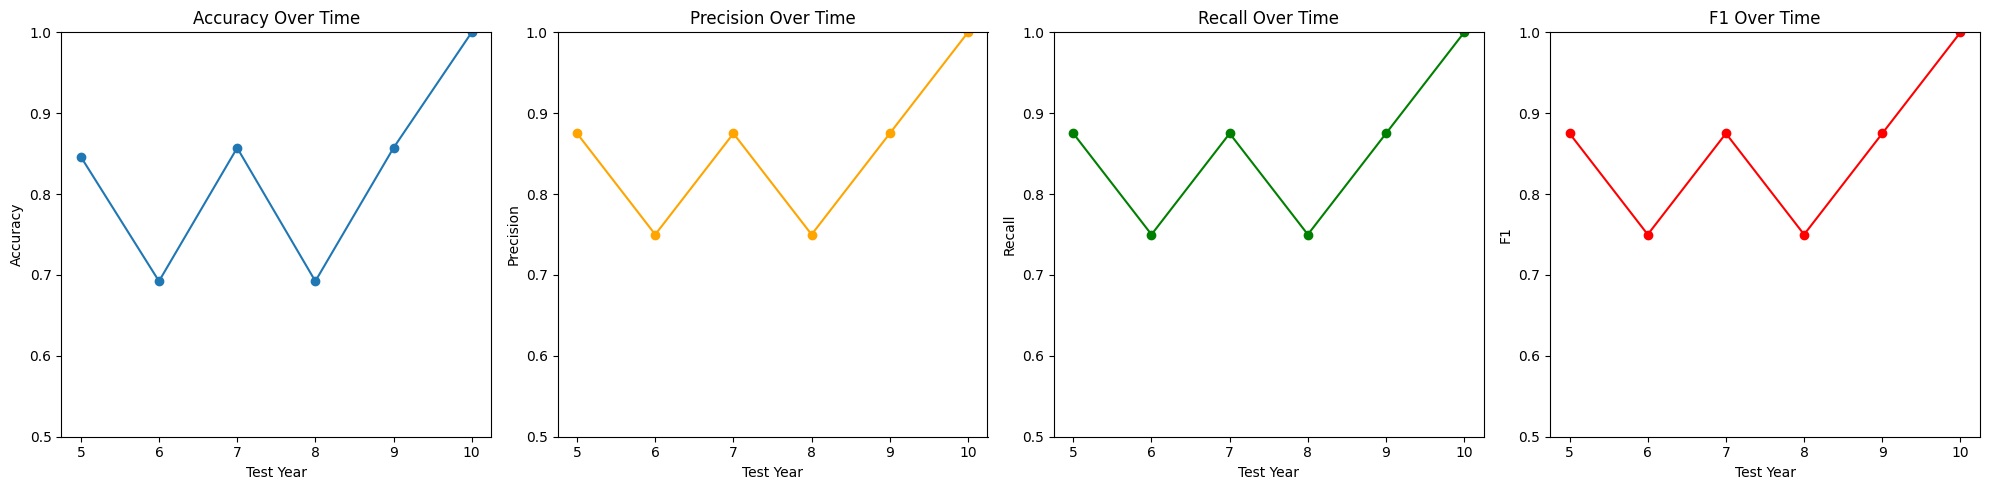

Accuracy:  0.8241758241758242
Precision:  0.8541666666666666
Recall:  0.8541666666666666
F1:  0.8541666666666666


In [ ]:
features = foward_selection(df_teams, RandomForestClassifier())
print(features)
model = RandomForestClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features])
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

### KNN

#### Hyperparameter tuning

In [ ]:

# model = KNeighborsClassifier()

# param_grid = {'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10],
#               'weights': ['uniform', 'distance'],
#               'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
#               'leaf_size': [10, 20, 30, 40, 50],
#               'p': [1, 2, 3],
#               'metric': ['minkowski', 'euclidean', 'manhattan']          
#               }
# grid = GridSearchCV(model, param_grid, cv=None)
# scaler=MinMaxScaler()
# X = scaler.fit_transform(df_teams.drop(columns=['playoff']))
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)
# KNeighborsClassifier(leaf_size=10, n_neighbors=10, p=3, weights='distance') 0.7864615384615383



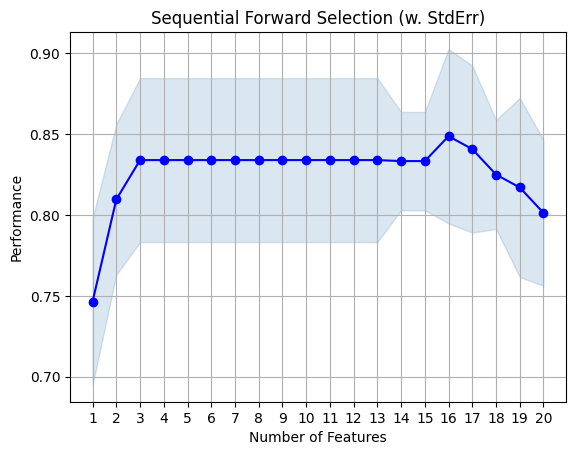

['rank', 'confW', 'confL', 'num_playoff_appearances', 'total_first_round_won', 'total_semis_won', 'total_semis_lost', 'total_finals_won', 'total_finals_lost', 'total_wins', 'total_losses', 'award_count_x', 'post_wins', 'award_count_y', 'W', 'L', 'playoff', 'year', 'tmID', 'confID_EA', 'confID_WE']


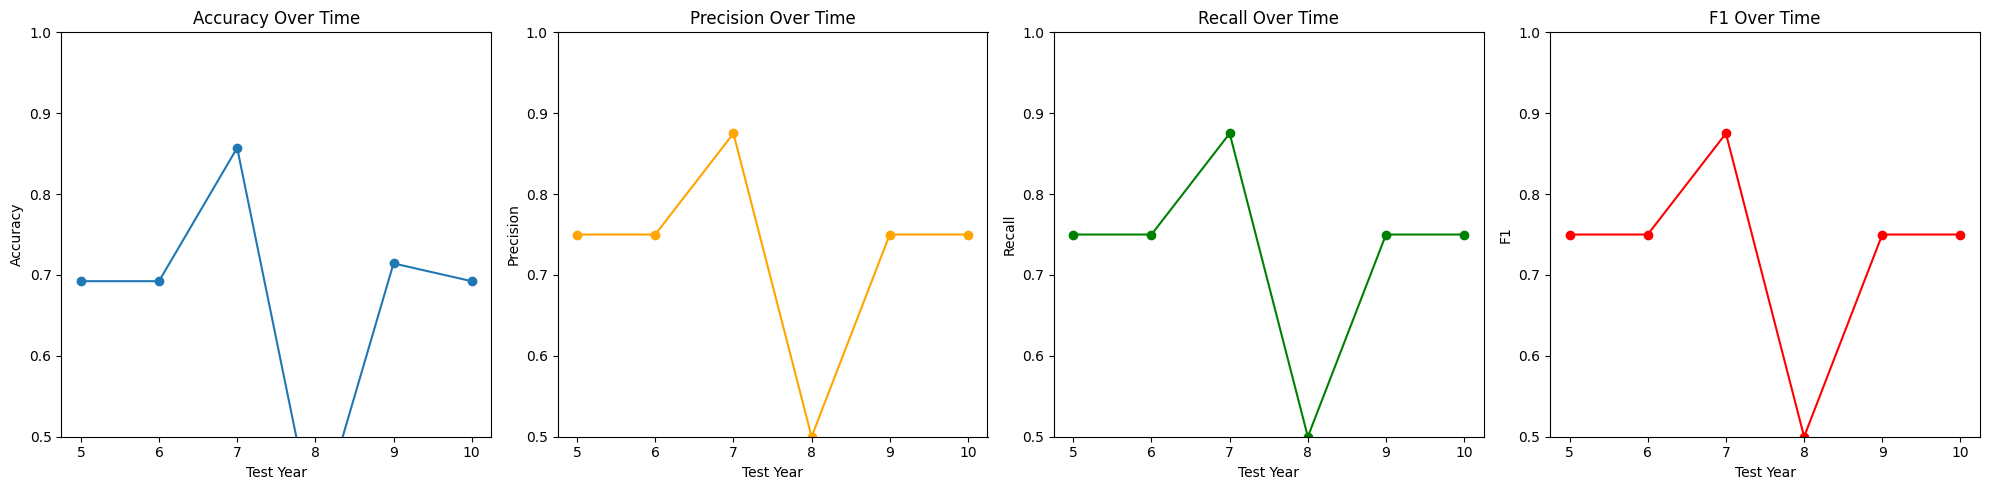

Accuracy:  0.6721611721611721
Precision:  0.7291666666666666
Recall:  0.7291666666666666
F1:  0.7291666666666666


In [ ]:
features = foward_selection(df_teams, KNeighborsClassifier())
print(features)
model = KNeighborsClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], scaling=True)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

### XGBoost

#### Hyperparameter tuning

In [ ]:

# model = XGBClassifier()

# param_grid = {'min_child_weight': [1, 5, 10],
#               'gamma': [0.5, 1, 1.5, 2, 5],
#               'subsample': [0.6, 0.8, 1.0],
#               'colsample_bytree': [0.6, 0.8, 1.0],
#               'max_depth': [3, 4, 5]
                    
#               }
# grid = GridSearchCV(model, param_grid, cv=None)
# scaler=MinMaxScaler()
# X = scaler.fit_transform(df_teams.drop(columns=['playoff']))
# y = df_teams['playoff']
# grid.fit(X, y)
# print(grid.best_estimator_, grid.best_score_)




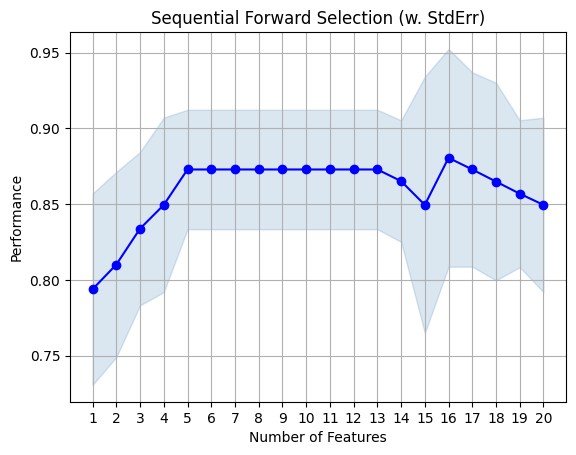

['tmID', 'rank', 'confW', 'confL', 'total_first_round_won', 'total_first_round_lost', 'total_semis_won', 'total_semis_lost', 'total_finals_won', 'total_finals_lost', 'total_wins', 'total_losses', 'GS', 'award_count_x', 'award_count_y', 'L', 'playoff', 'year', 'confID_EA', 'confID_WE']


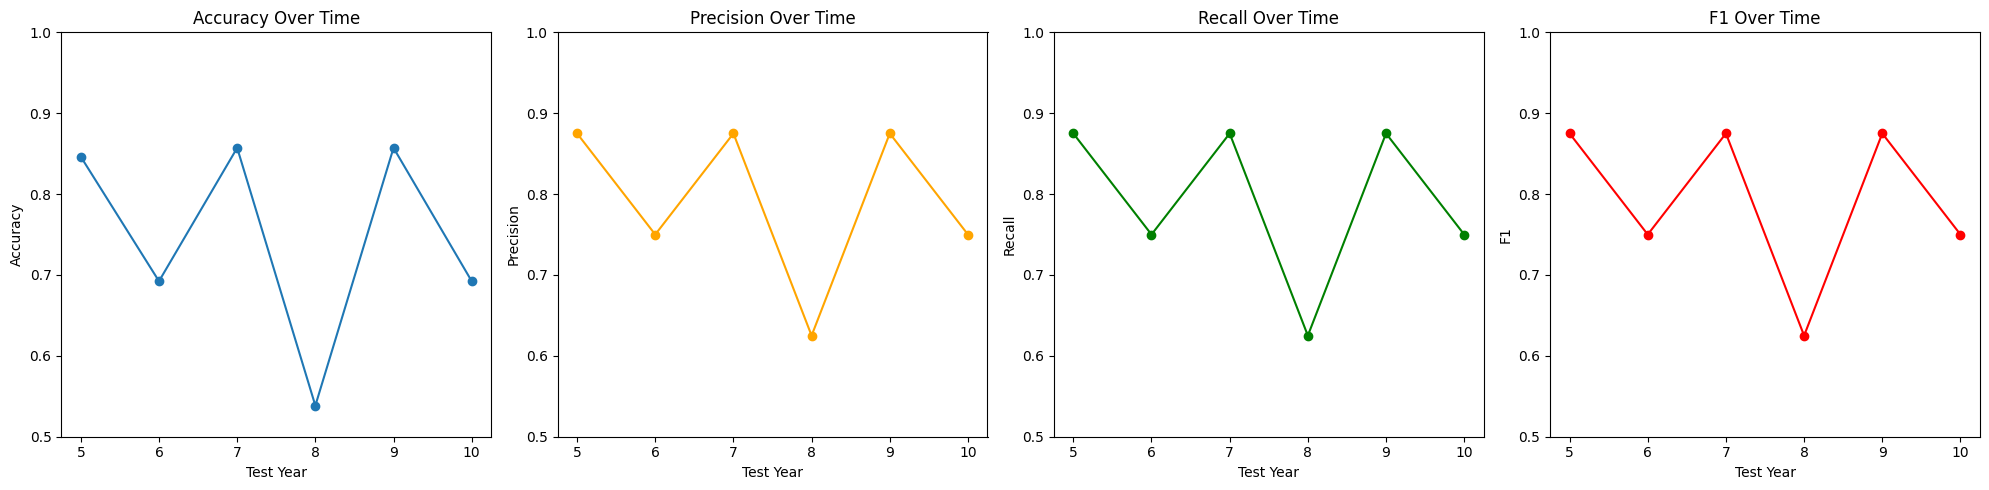

Accuracy:  0.7472527472527473
Precision:  0.7916666666666666
Recall:  0.7916666666666666
F1:  0.7916666666666666


In [ ]:
features = foward_selection(df_teams, XGBClassifier())
print(features)
model = XGBClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features])
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)


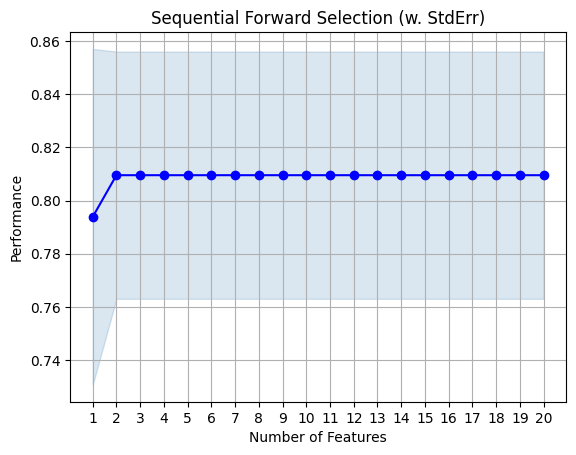

['year', 'tmID', 'rank', 'total_wins', 'L', 'playoff', 'confID_EA', 'confID_WE']


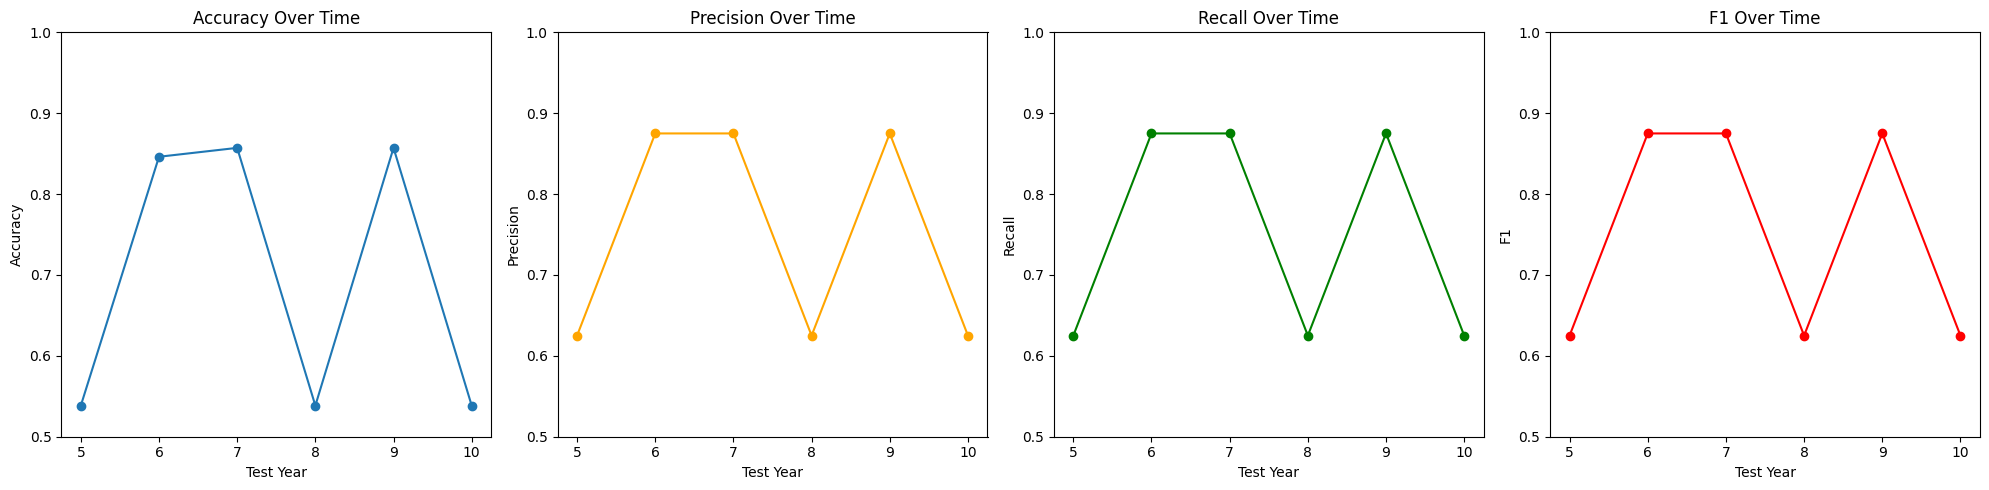

Accuracy:  0.695970695970696
Precision:  0.75
Recall:  0.75
F1:  0.75


In [ ]:
features = foward_selection(df_teams, GaussianNB())
print(features)
model = GaussianNB()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features])
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

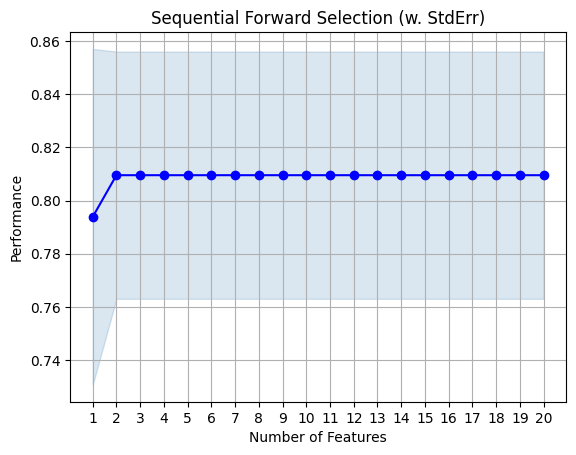

['year', 'rank', 'num_playoff_appearances', 'total_wins', 'L', 'playoff', 'tmID', 'confID_EA', 'confID_WE']


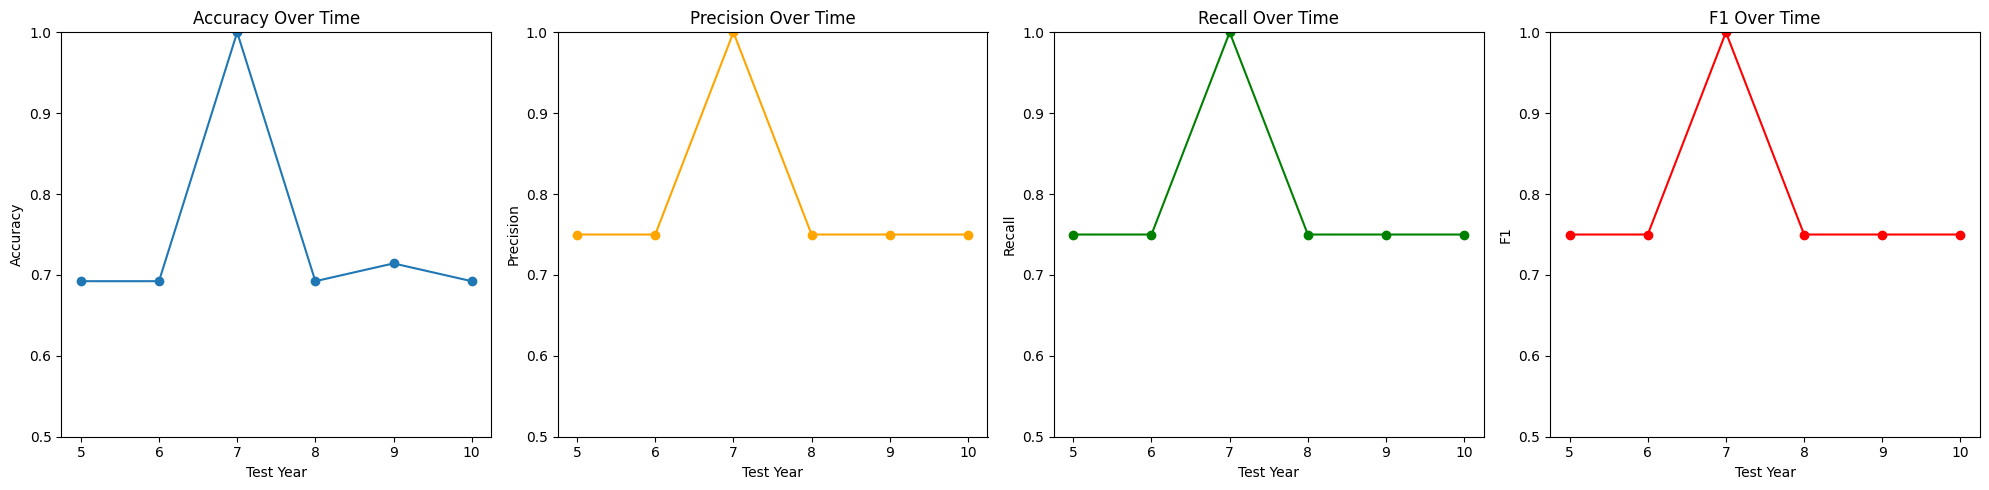

Accuracy:  0.7472527472527473
Precision:  0.7916666666666666
Recall:  0.7916666666666666
F1:  0.7916666666666666


In [ ]:
features = foward_selection(df_teams,SVC(probability=True) )
print(features)
model =SVC(probability=True)
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], scaling=True)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

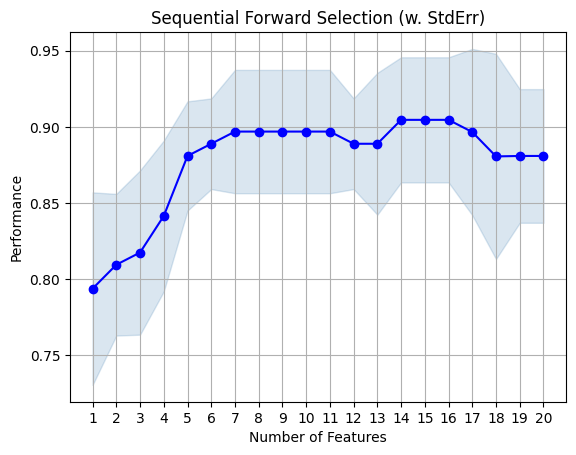

['rank', 'total_semis_won', 'total_semis_lost', 'total_finals_won', 'total_finals_lost', 'total_wins', 'total_losses', 'GS', 'oRebounds', 'weight', 'award_count_x', 'won', 'W', 'L', 'playoff', 'year', 'tmID', 'confID_EA', 'confID_WE']


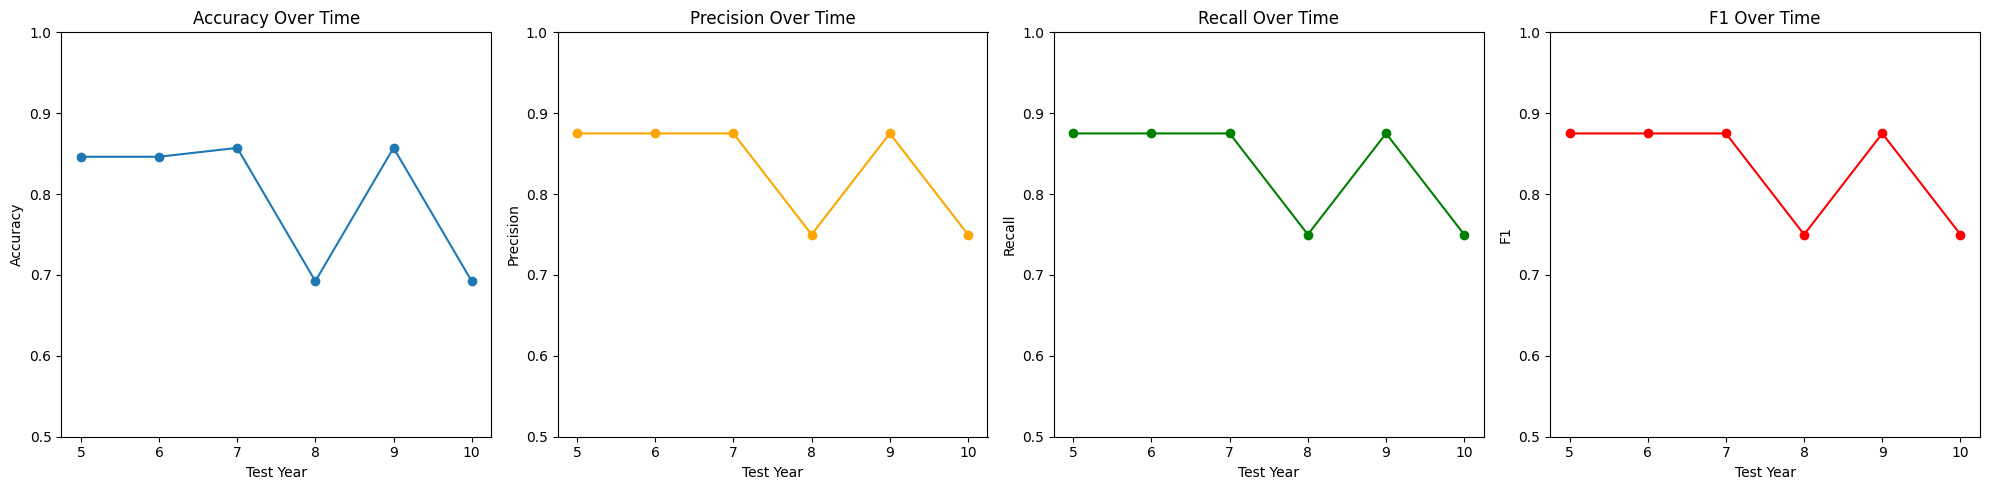

Accuracy:  0.7985347985347985
Precision:  0.8333333333333334
Recall:  0.8333333333333334
F1:  0.8333333333333334


In [ ]:
features = foward_selection(df_teams, LogisticRegression())
print(features)
model = LogisticRegression()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], scaling=True)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)

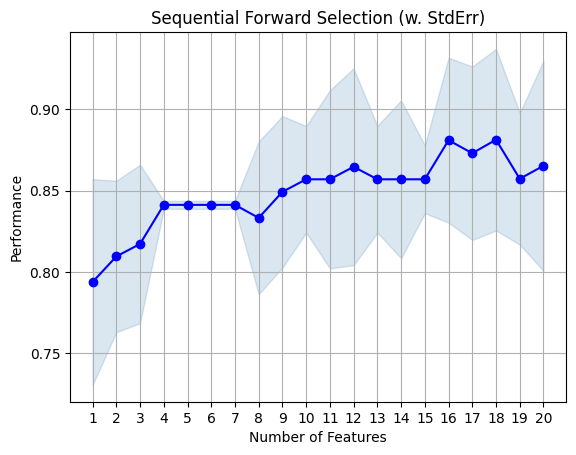

['tmID', 'num_playoff_appearances', 'total_first_round_won', 'total_first_round_lost', 'total_semis_won', 'total_finals_won', 'total_finals_lost', 'confID_EA', 'confID_WE', 'total_wins', 'GS', 'dq', 'award_count_x', 'lost', 'post_wins', 'post_losses', 'W', 'L', 'playoff', 'year']


C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\jigs2\A

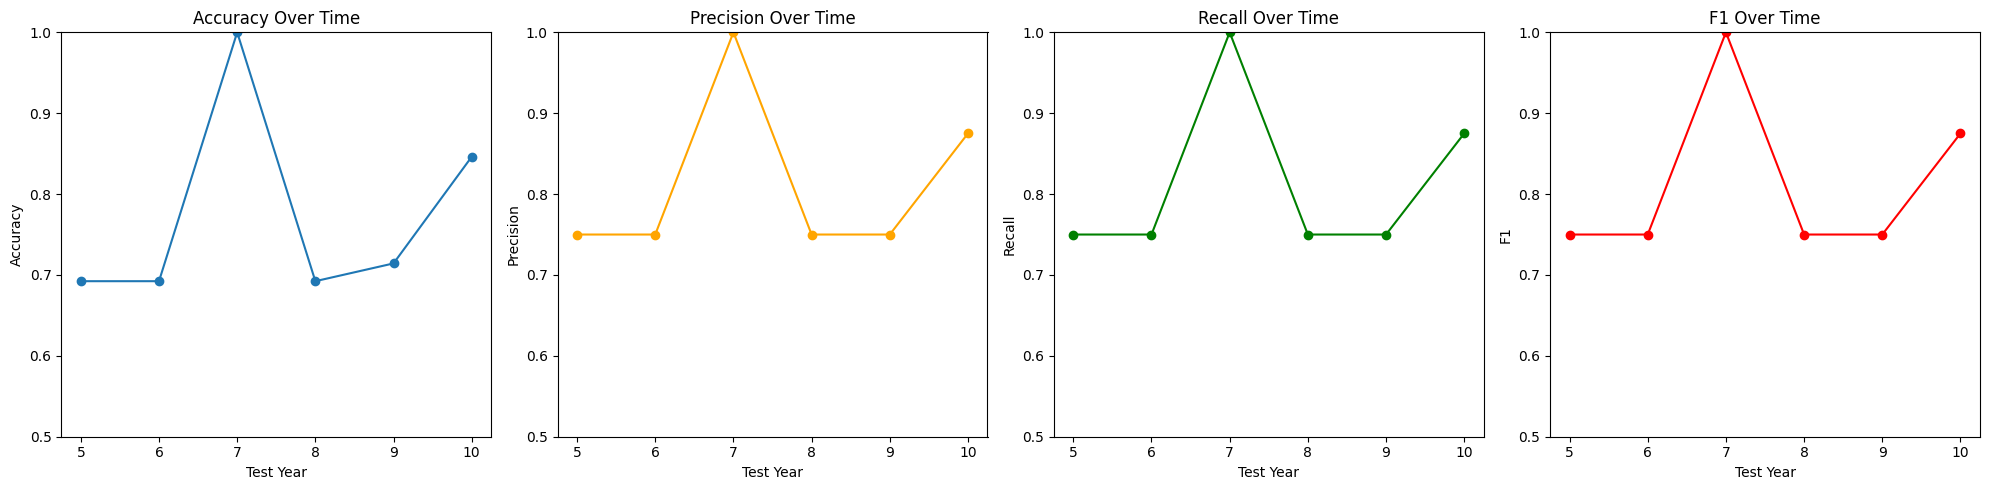

Accuracy:  0.7728937728937728
Precision:  0.8125
Recall:  0.8125
F1:  0.8125


In [ ]:
features = foward_selection(df_teams, MLPClassifier())
print(features)
model = MLPClassifier()
years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores = train_evaluate_decision_tree_graph(model, df_teams[features], scaling=True)
plot_metrics_over_time(years_tested, accuracy_scores, precision_scores, recall_scores, f1_scores)